In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score

# download data
!wget https://github.com/yowangPVAMU/PythonCV/raw/refs/heads/main/Food-101-Practice-data.zip
!unzip Food-101-Practice-data.zip

# Input data files are available in the "./Food-101-Practice-data(three class)" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the data directory

import os
for dirname, _, filenames in os.walk('./Food-101-Practice-data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


--2025-07-17 04:10:09--  https://github.com/yowangPVAMU/PythonCV/raw/refs/heads/main/Food-101-Practice-data.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yowangPVAMU/PythonCV/refs/heads/main/Food-101-Practice-data.zip [following]
--2025-07-17 04:10:09--  https://raw.githubusercontent.com/yowangPVAMU/PythonCV/refs/heads/main/Food-101-Practice-data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15776180 (15M) [application/zip]
Saving to: ‘Food-101-Practice-data.zip’

Food-101-Practice-d 100%[===================>]  15.04M  --.-KB/s    in 0.1s    

2025-07-17 04:10:09 (127 MB/s) - ‘Food-1

In [2]:
import torch
from torch import nn
import torch.optim as optim

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.6.0+cu124'

In [3]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
import requests
from pathlib import Path

# Setup path to data folder
data_path = Path(".")
image_path = data_path / "Food-101-Practice-data"
image_path

PosixPath('Food-101-Practice-data')

In [5]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'Food-101-Practice-data'.
There are 3 directories and 0 images in 'Food-101-Practice-data/test'.
There are 0 directories and 25 images in 'Food-101-Practice-data/test/pizza'.
There are 0 directories and 31 images in 'Food-101-Practice-data/test/sushi'.
There are 0 directories and 19 images in 'Food-101-Practice-data/test/steak'.
There are 3 directories and 0 images in 'Food-101-Practice-data/train'.
There are 0 directories and 78 images in 'Food-101-Practice-data/train/pizza'.
There are 0 directories and 72 images in 'Food-101-Practice-data/train/sushi'.
There are 0 directories and 75 images in 'Food-101-Practice-data/train/steak'.


In [7]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('Food-101-Practice-data/train'),
 PosixPath('Food-101-Practice-data/test'))

Random image path: Food-101-Practice-data/train/steak/75537.jpg
Image class: steak
Image height: 384
Image width: 512


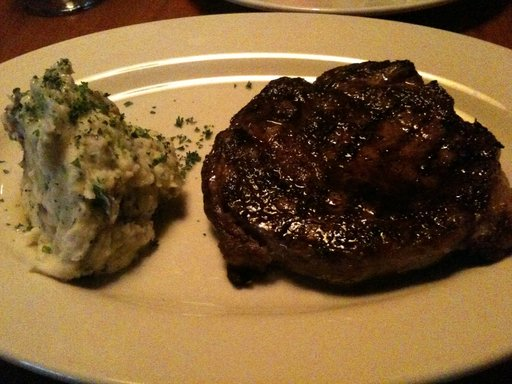

In [8]:
import random
from PIL import Image

# Set seed
#random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

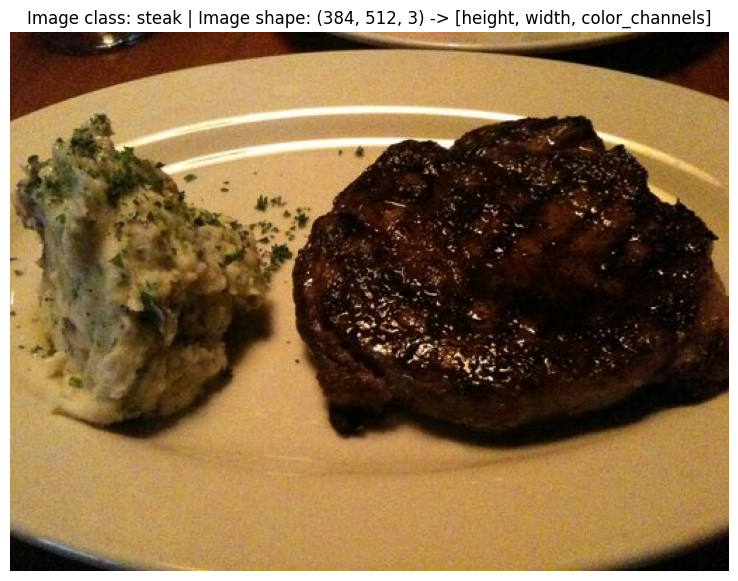

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [85]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

# 1.->Testing Transformation with one image

Text(0.5, 0.98, 'Class: pizza')

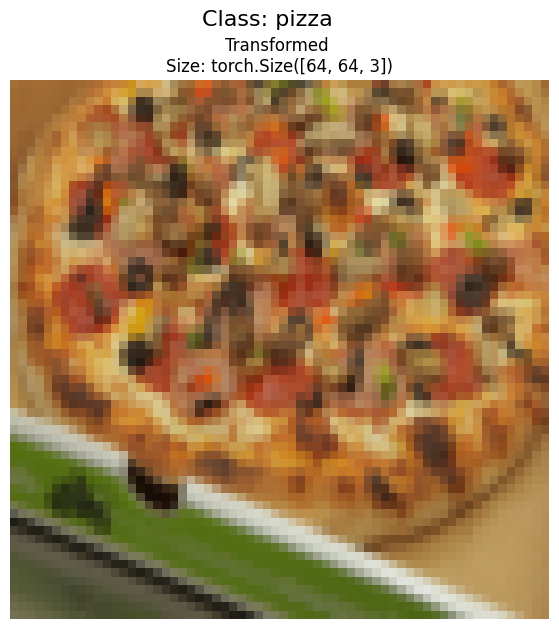

In [86]:
test_img_path =random.sample(image_path_list, k=1)
pil_image = Image.open(str(test_img_path[0]))
test_transformed_image = data_transform(pil_image).permute(1, 2, 0)
plt.figure(figsize=(10, 7))
plt.imshow(test_transformed_image)
plt.title(f"Transformed \nSize: {test_transformed_image.shape}")
plt.axis(False)
plt.suptitle(f"Class: {test_img_path[0].parent.stem}", fontsize=16)


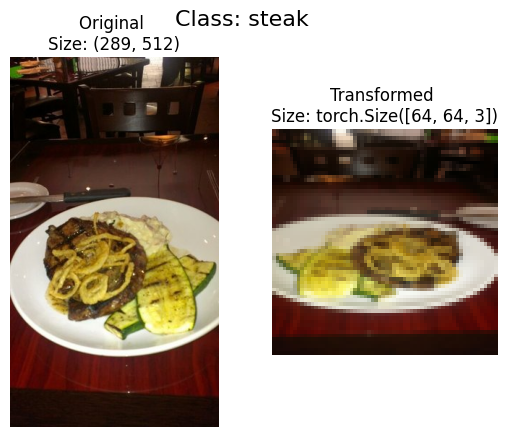

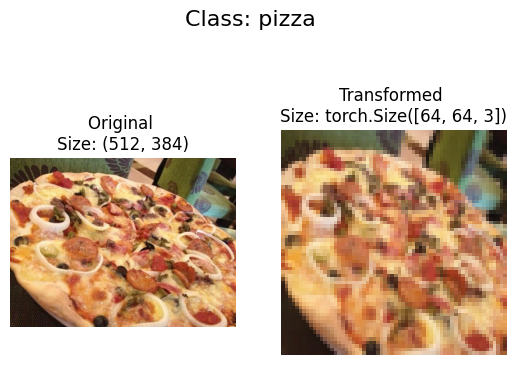

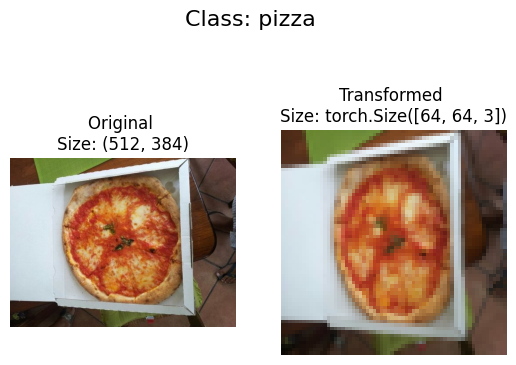

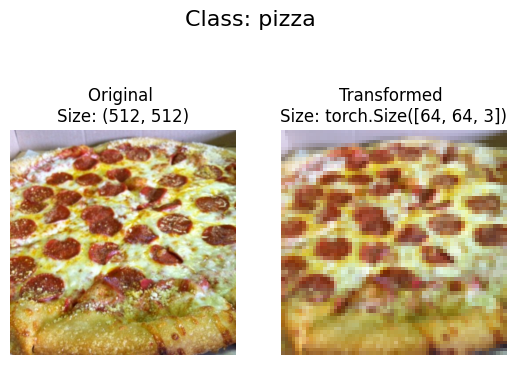

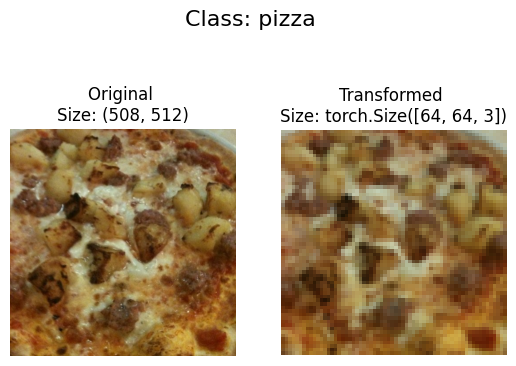

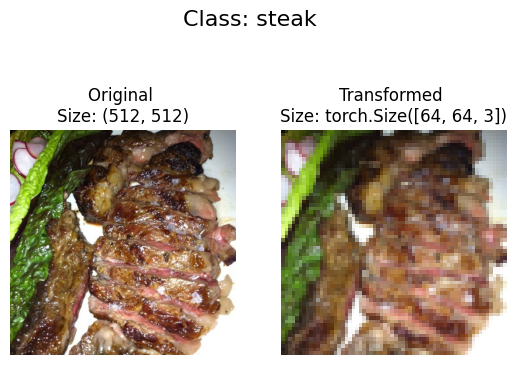

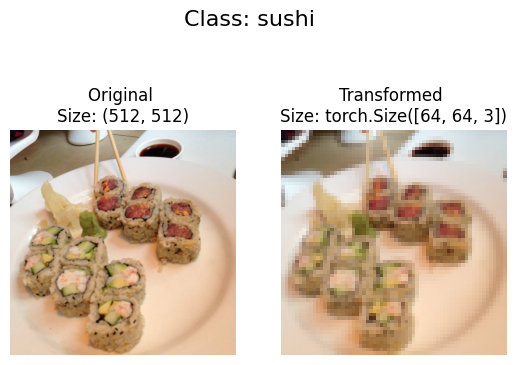

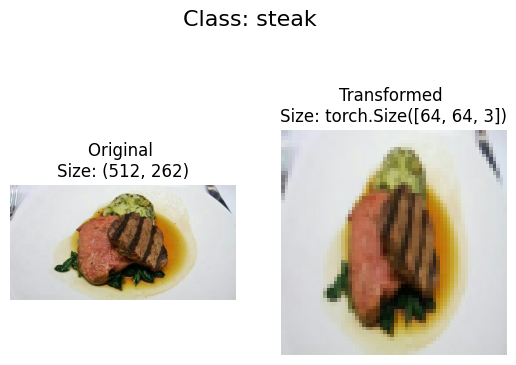

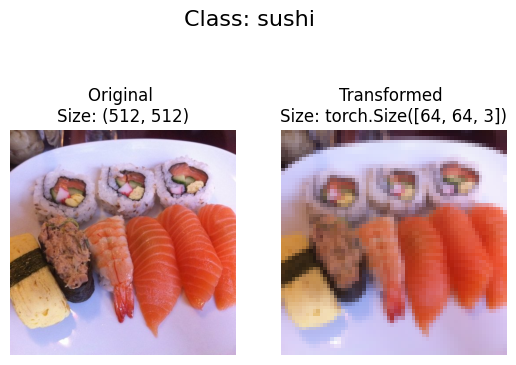

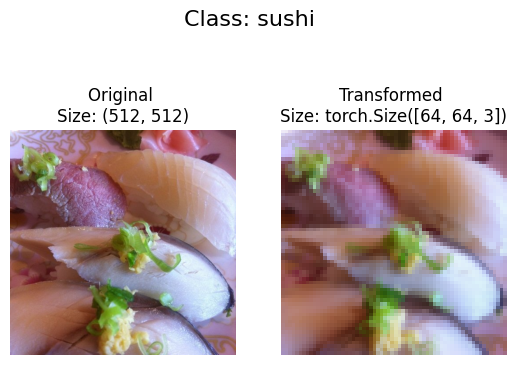

In [87]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    #print(f'random_image_paths : {random_image_paths}')
    for image_path in random_image_paths:
        #print(f'type of image_path :{type(image_path)}')
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=10)

# Loading Image data into torchvision.datasets.ImageFolder.

In [88]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)
print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: Food-101-Practice-data/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: Food-101-Practice-data/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [89]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [90]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [91]:
# Check the lengths
len(train_data), len(test_data)

(225, 75)

In [92]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


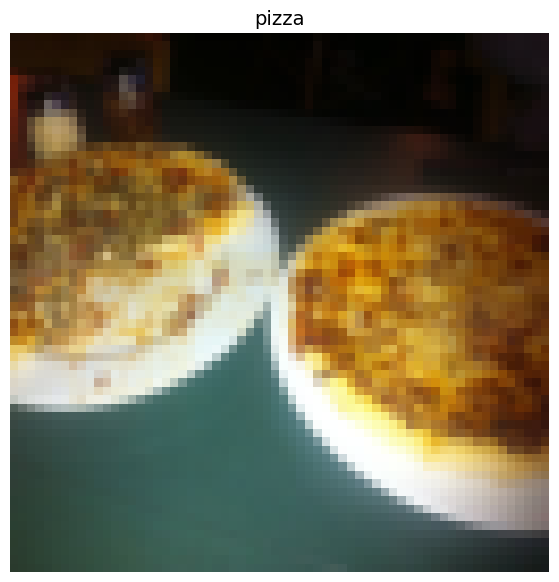

In [93]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [94]:
train_data # this is mainly pythorch data set

Dataset ImageFolder
    Number of datapoints: 225
    Root location: Food-101-Practice-data/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [95]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7cc61b5ffe90>,
 <torch.utils.data.dataloader.DataLoader at 0x7cc620d00a10>)

In [96]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


In [97]:
from typing import Tuple, Dict, List
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.

    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))

    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

    # 3. Crearte a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [98]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=20,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=5120, out_features=3, bias=True)
  )
)

In [99]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)

        # Reset the optimizer
        optimizer.zero_grad()

        # Push the data forward through the model layers
        output = model(data)


        # Get the loss
        loss = loss_criteria(output, target)

        # Keep a running total
        train_loss += loss.item()

        # Backpropagate
        loss.backward()
        optimizer.step()

        # Print metrics for every 10 batches so we see some progress
        if batch_idx % 10 == 0:
            print(f'Training set:{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader)} Loss:{loss.item()})')
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

In [100]:
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    target_all = []
    predicted_all = []
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)

            # Get the predicted classes for this batch
            output = model(data)

            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()

            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()
            # Append scalar target and predicted values after moving into cpu
            target_all.extend(target.cpu().numpy())
            predicted_all.extend(predicted.cpu().numpy())


    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print(f'Validation set: Average loss: {avg_loss}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset)}%)')
    # Calculate Precision, Recall, and F1-score using scikit-learn functions
    precision = round(precision_score(target_all, predicted_all, average='weighted'),2)
    recall = round(recall_score(target_all, predicted_all, average='weighted'),2)
    f1 = round(f1_score(target_all, predicted_all, average='weighted'),2)
    precision2 = round(precision_score(target_all, predicted_all, average='micro'),2)
    recall2 = round(recall_score(target_all, predicted_all, average='micro'),2)
    f1_2 = round(f1_score(target_all, predicted_all, average='micro'),2)
    accuracy = round((accuracy_score(target_all, predicted_all)*100),2)
    # Printing the accuracy
    print(f'Validation set: Average loss: {avg_loss},Accuracy: {accuracy}%, Weighted precision:{precision}, Weighted recall:{recall},Weighted f1:{f1}')
    print(f'Micro precision:{precision2}, Micro recall:{recall2}, Micro f1:{f1_2}')
   # return average loss for the epoch
    return avg_loss,accuracy, precision, recall, f1

In [101]:
device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"
print('Training on', device)

# Create an instance of the model class and allocate it to the device
# model = model.to(device)

# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model_0.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []
accuracy = []

# Train over  epochs
epochs = 20
for epoch in range(1, epochs + 1):
        train_loss = train(model_0, device, train_dataloader, optimizer, epoch)
        test_loss = test(model_0, device, test_dataloader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss[0])
        accuracy.append(test_loss[1])


Training on cpu
Epoch: 1
Training set:0/225 (0.0 Loss:1.1138637065887451)
Training set:10/225 (4.444444444444445 Loss:1.3967572450637817)
Training set:20/225 (8.88888888888889 Loss:0.9438640475273132)
Training set:30/225 (13.333333333333334 Loss:0.7734841108322144)
Training set:40/225 (17.77777777777778 Loss:1.4293580055236816)
Training set:50/225 (22.22222222222222 Loss:0.5501788258552551)
Training set:60/225 (26.666666666666668 Loss:0.629711389541626)
Training set:70/225 (31.11111111111111 Loss:1.042163372039795)
Training set:80/225 (35.55555555555556 Loss:1.2118580341339111)
Training set:90/225 (40.0 Loss:0.9928689002990723)
Training set:100/225 (44.44444444444444 Loss:1.1230014562606812)
Training set:110/225 (48.888888888888886 Loss:1.1345467567443848)
Training set:120/225 (53.333333333333336 Loss:1.1522516012191772)
Training set:130/225 (57.77777777777778 Loss:1.103338360786438)
Training set:140/225 (62.22222222222222 Loss:1.088520884513855)
Training set:150/225 (66.66666666666667

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training set:0/225 (0.0 Loss:1.144012689590454)
Training set:10/225 (4.444444444444445 Loss:1.1481150388717651)
Training set:20/225 (8.88888888888889 Loss:1.0879480838775635)
Training set:30/225 (13.333333333333334 Loss:1.1445969343185425)
Training set:40/225 (17.77777777777778 Loss:1.0492758750915527)
Training set:50/225 (22.22222222222222 Loss:1.1756113767623901)
Training set:60/225 (26.666666666666668 Loss:1.1025495529174805)
Training set:70/225 (31.11111111111111 Loss:1.1269164085388184)
Training set:80/225 (35.55555555555556 Loss:1.1210150718688965)
Training set:90/225 (40.0 Loss:0.9971120357513428)
Training set:100/225 (44.44444444444444 Loss:1.226296067237854)
Training set:110/225 (48.888888888888886 Loss:1.1032218933105469)
Training set:120/225 (53.333333333333336 Loss:1.0325939655303955)
Training set:130/225 (57.77777777777778 Loss:1.1158853769302368)
Training set:140/225 (62.22222222222222 Loss:1.2118194103240967)
Training set:150/225 (66.66666666666667 Loss:0.800339221954345

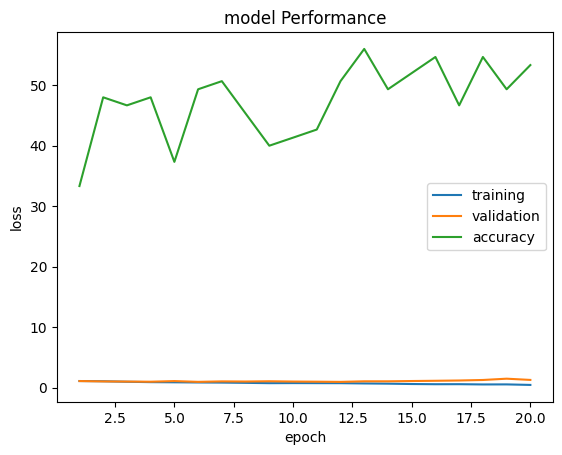

In [102]:
from matplotlib import pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.plot(epoch_nums, accuracy)
plt.title('model Performance')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation','accuracy'], loc='center right')
plt.show()

In [103]:
print(f'Max Accuracy is {max(accuracy)}%')
print(f'At Epoch {accuracy.index(max(accuracy))+1}')

Max Accuracy is 56.0%
At Epoch 13


In [104]:
print(f'Min Validation Loss is {min(validation_loss)}')
print(f'At Epoch {validation_loss.index(min(validation_loss))+1}')

Min Validation Loss is 0.9573824329550068
At Epoch 12
